# Unsupervised Clustering using a Mixture Model

In [0]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
!pip install pymc3

  Using cached https://files.pythonhosted.org/packages/32/19/6c94cbadb287745ac38ff1197b9fadd66500b6b9c468e79099b110c6a2e9/pymc3-3.8-py3-none-any.whl


In [0]:
!pip install arviz

In [0]:
from google.colab import files
uploaded = files.upload()

Saving mixture_data.csv to mixture_data.csv


[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


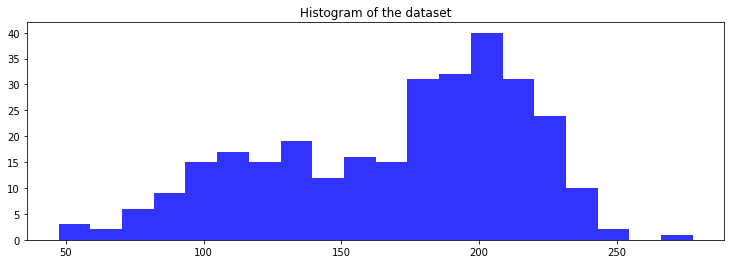

In [0]:
figsize(12.5, 4)
data = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="b", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")


It appears the data has a bimodal form, that is, it appears to have two peaks, one near 120 and the other near 200. Perhaps there are two clusters within this dataset.

Do you know of a good analytic function that has two peaks? I don't. So, let's assume it comes from mixing two analytic functions, each with their own peak. Like good data scientists, we start with normal distributions. Let's try the following generative technique:

For each data point, choose cluster 1 with probability  𝑝 , else choose cluster 2.
Draw a random variate from a Normal distribution with parameters  𝜇𝑖  and  𝜎𝑖  where  𝑖  was chosen in step 1.
Repeat.
This algorithm would create a similar effect as the observed dataset, so we choose this as our model. Finding the right parameters (but wait, there's still a bit of art there too, since we have to guess good pdfs for the parameters as well!).

We do not know  𝑝  or the parameters of the Normal distributions. So we must infer, or learn, these unknowns. This is what Bayesian MCMC programms allow us to do.

Ready?

Denote the Normal distributions  N0  and  N1 . Both currently have unknown mean and standard deviation, denoted  𝜇𝑖  and  𝜎𝑖,𝑖=0,1  respectively. A specific data point can be from either  N0  or  N1 , and we assume that the data point is assigned to  N0  with probability  𝑝 , to  N1  with probability  1−𝑝 .

An appropriate way to assign data points to clusters is to use a PyMC3 Categorical stochastic variable. Its parameter is a  𝑘 -long array of probabilities that must sum to one and its value attribute is an integer between 0 and  𝑘−1 , randomly chosen according to the crafted array of probabilities (in our case  𝑘=2 ).

A priori, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on  (0,1) . We call call this  𝑝1 . The probability of belonging to cluster 2 is therefore  𝑝2=1−𝑝1 . Note we should not use a normal variable, because that presupposes an expectation of 0.5, however in this case we have no expectation for each datapoint!

Unfortunately, we can't we just give [p1, p2] to our Categorical variable. PyMC3 uses Theano under the hood to build the models so we need to use theano.tensor.stack() to combine  𝑝1  and  𝑝2  into a vector that it can understand. We pass this vector into the Categorical variable as well as the testval parameter to give our variable an idea of where to start from: 300 random 0s and 1s for each of our 300 datapoints, indicating they belong to either cluster 0 or cluster 1.

In [0]:
data.shape[0]

300

Since we have 300 datapoints, we assign each point randomly to either cluster 0 or cluster 1. assignment is a Categorical probabilistic variable of shape (300,) that takes the values 0 and 1,

In [0]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    
    # this produces worse results. Why? This looks like a categorical assignment with Bernoulli probability
    #assignment = pm.Categorical('assignment', np.array([0.5, 0.5]), 
    #                            shape = data.shape[0],
    #                            testval = np.random.randint(0, 2, data.shape[0]))
    
    # This is better: This looks like a categorical assignment with Dirichlet probabilty 
    assignment = pm.Categorical("assignment", p, 
                                shape = data.shape[0],
                                testval = np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:100])

prior assignment, with p = 0.50:
[0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1
 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1
 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0]


Now let's guess the probability distribution for our model parameters!

Looking at my dataset histogram, I would guess that the standard deviations of the two Normal distributions representing each cluster are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

sds = pm.Uniform("sds", 0, 100, shape=2)
Notice that we specified shape=2: we are modeling both  𝜎 s as a single PyMC3 variable. Note that this does not induce a necessary relationship between the two  𝜎 s, it is simply for succinctness. You could have picked two different variables.

We also need to specify priors on the centers of the clusters. The centers are really the  𝜇  parameters in these Normal distributions. Their priors can be modeled by a Normal distribution because, looking at the data, I have somewhat of an idea where the two centers might be — I would guess somewhere around 120 and 190 respectively, though I am not very confident in these eyeballed estimates. Hence I will set  𝜇0=120,𝜇1=190  and  𝜎0=𝜎1=10 .

I will also assign a deterministic (the opposite of probabilistic) variable to each probabilistic sds and centers variable.

Let's do all this!

sds is a Uniform distribution in [0, 100], in 2 dimensions (of shape 2)

centers is a Normal distribution with mean 120 and standard deviation 10 in one dimension, and mean 120 and standard deviation 10 in the other dimension

center_i is a (deterministic) array of values that changes with each assignment variable. When assignment is = 0, it denotes centers[0], and when assignment is = 1, it denotes centers[1]. So the length of center_i is 300

sd_i is a (deterministic) array of values that changes with each assignment variable. When assignment is = 0, it denotes sds[0], and when assignment is = 1, it denotes sds[1]. So the length of sd_i is 300

observations is a probabilistic Normal distribution that fits the observed data, with mean and standard deviation that changes for each datapoint in data. So sometimes it's centers[0] and sds[0], and other times it's centers[1] and sds[1], depending on the assignment value of each datapoint



In [0]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:100], "...")
print("Assigned center: ", center_i.tag.test_value[:100], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:100])

Random assignments:  [0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1
 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1
 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0] ...
Assigned center:  [120. 120. 190. 190. 120. 120. 120. 120. 120. 190. 120. 190. 120. 120.
 120. 190. 120. 190. 190. 190. 120. 190. 190. 190. 190. 120. 120. 120.
 190. 190. 120. 120. 120. 120. 190. 120. 190. 120. 120. 190. 120. 190.
 190. 120. 190. 120. 190. 120. 190. 120. 190. 120. 190. 190. 190. 190.
 190. 190. 190. 120. 120. 190. 120. 120. 120. 120. 190. 190. 190. 190.
 120. 190. 120. 190. 120. 120. 190. 120. 120. 120. 190. 190. 190. 120.
 120. 120. 190. 190. 120. 120. 120. 120. 190. 190. 190. 190. 190. 120.
 190. 120.] ...
Assigned standard deviation:  [50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.

So that is what we start with: random assignments for each datapoint.

Notice how we continue to build the model within the context of Model(). This automatically adds the variables that we create to our model. As long as we work within this context we will be working with the same variables that we have already defined. Any sampling that we do within the context of Model() will be done only on the model in which we are working.

We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case Metropolis() for our continuous variables and ElemwiseCategorical() for our categorical variable (Metropolis does not work for discrete variables).

We will use these sampling methods to explore the space by using sample(iterations, step), where iterations is the number of steps we wish the algorithm to perform and step is the way in which we want to handle those steps.

We use our combination of Metropolis() and ElemwiseCategorical() for the step and sample 25,000 iterations:

**We sample from the posterior at every time step of our iteration, and this gives us different samples of all our model paramters. At each time step we get closer and closer to pdfs for our model parameters (mu and sd) that yield the data likelihood observations pdf which fits our empirical histogram the best. So when we converge, we have the exact modeling solution for our empirical data as model distributions, yeilding best point approximations as well as errors made (standard deviation).**

In [0]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2],cores=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
100%|██████████| 25500/25500 [03:26<00:00, 123.38it/s]
The number of effective samples is smaller than 10% for some parameters.


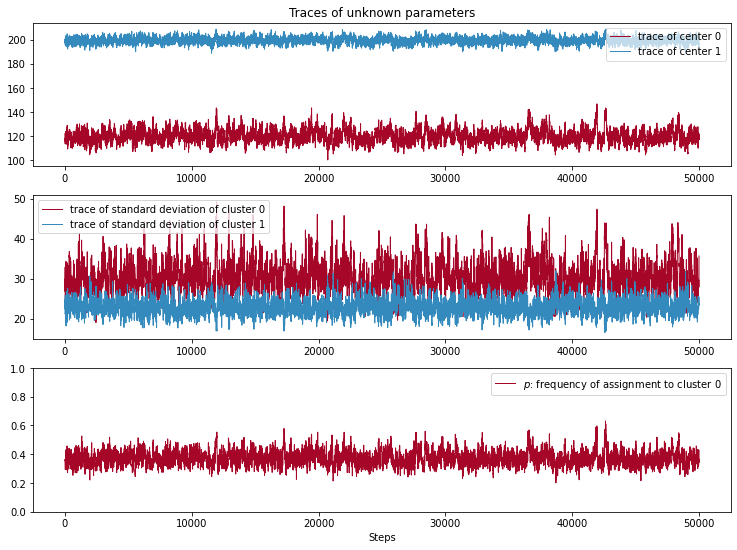

In [0]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# pretty colors
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();


# Cluster Investigation

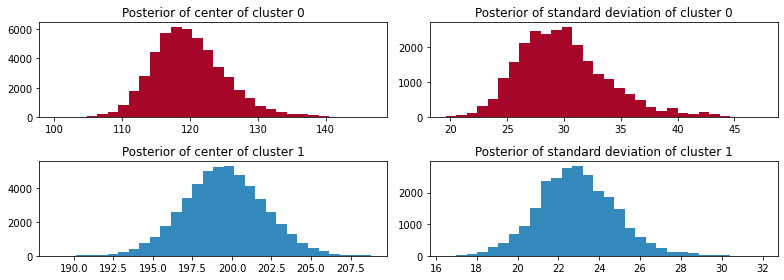

In [0]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. The most likely standard deviation is 30 for cluster 0, and 22 for cluster 1.

We are also given the posterior distributions for the labels of the data point, which is present in trace["assignment"]. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0.

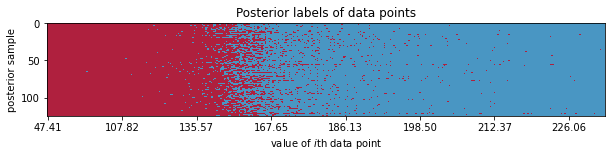

In [0]:
import matplotlib as mpl
figsize(10, 10)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");


Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the  𝑖 th sorted data point). A more clear diagram is below, where we estimate the frequency of each data point belonging to labels 0 and 1:

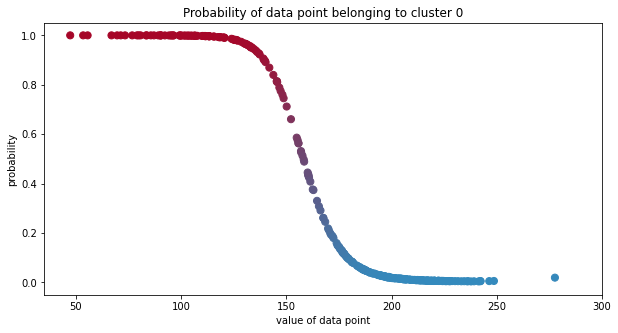

In [0]:
figsize(10, 5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");


In [0]:
trace["p"].mean()

0.37375398099576784

Sequential sampling (2 chains in 1 job)
Metropolis: [x]
100%|██████████| 10500/10500 [00:01<00:00, 7559.55it/s]
The number of effective samples is smaller than 25% for some parameters.


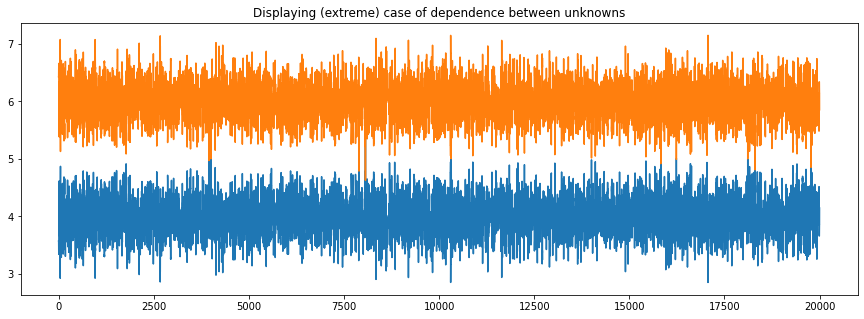

In [0]:
import pymc3 as pm

with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");


# MCMC Mixture Model

In [0]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)
import matplotlib.pyplot as plt

### Poisson Model 

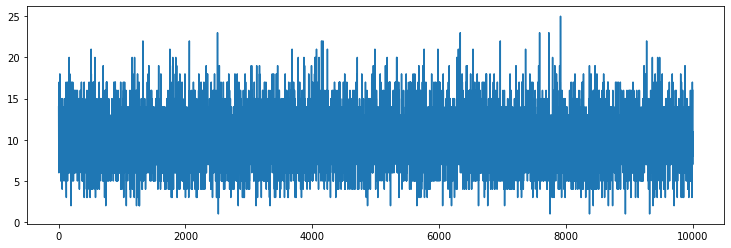

In [0]:
true_rate = 10
n_obs = 10000
poisson_number_of_emails = np.random.poisson(true_rate, n_obs)
plt.plot(poisson_number_of_emails)

(array([6.25000e-04, 2.75000e-03, 9.75000e-03, 2.50000e-02, 0.00000e+00,
        4.61250e-02, 7.60000e-02, 1.10500e-01, 1.46875e-01, 0.00000e+00,
        1.55000e-01, 1.55375e-01, 1.39875e-01, 1.25000e-01, 0.00000e+00,
        8.86250e-02, 6.28750e-02, 4.50000e-02, 2.71250e-02, 0.00000e+00,
        1.66250e-02, 7.62500e-03, 3.87500e-03, 2.50000e-03, 0.00000e+00,
        1.37500e-03, 8.75000e-04, 5.00000e-04, 0.00000e+00, 1.25000e-04]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ,
         9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. , 17.8,
        18.6, 19.4, 20.2, 21. , 21.8, 22.6, 23.4, 24.2, 25. ]),
 <a list of 1 Patch objects>)

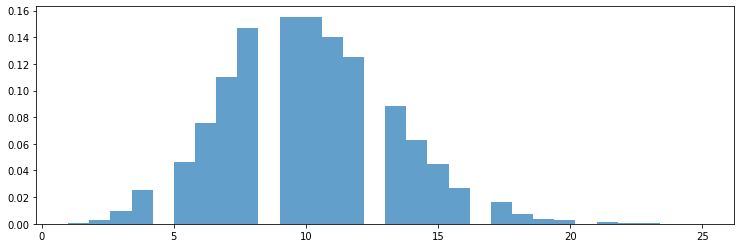

In [0]:
plt.hist(poisson_number_of_emails, 30, density=True, histtype='stepfilled', alpha=0.7)

In [0]:
import pymc3 as pm
import theano.tensor as T

# fit a pymc3 model to get the rate
with pm.Model() as email_model:
    lambda_prior = pm.Uniform('lambda_prior', 0, 20)

    #likelihood
    Y_obs = pm.Poisson('Y_obs', mu = lambda_prior, observed = poisson_number_of_emails)

In [0]:
with email_model:
    trace = pm.sample(2000, chains = 2, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda_prior]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1157.43it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06d75c6ac8>,
      dtype=object)

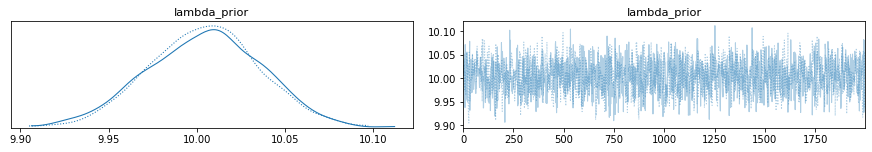

In [0]:
pm.traceplot(trace)

In [0]:
trace["lambda_prior"].mean()

10.003834600407256

## Gaussian mixture model

The simplest ML library is always scikit-learn: Just one call to a .fit() function. So let's do a Gaussian Mixture Model with scikit-learn

In [0]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture

from matplotlib.colors import LogNorm


# %load std_ipython_import.txt
import pandas as pd
import scipy as spy


import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We use three different normal models that we concatenate and then reshape into a 2D array, since that is what scikit-learn's .fit() API expects.

NOTE: Use X.reshape(-1, 1) if your data has a single feature/column and X.reshape(1, -1) if it contains a single sample

In [0]:
random_state = np.random.RandomState(seed=1)

In [0]:
np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).shape

(1000,)

In [0]:
np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1).shape

(1000, 1)

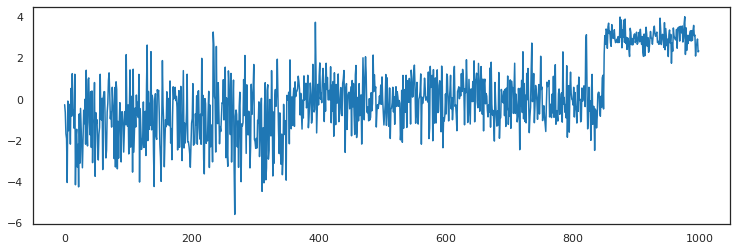

In [0]:
X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)
plt.plot(X)

(array([0.0031234 , 0.        , 0.        , 0.0031234 , 0.02186382,
        0.01561702, 0.01561702, 0.05622126, 0.04060424, 0.05309786,
        0.11244252, 0.0937021 , 0.10307231, 0.22488505, 0.21551484,
        0.26236589, 0.25299568, 0.28422971, 0.24362547, 0.22800845,
        0.14367656, 0.14055315, 0.06871488, 0.03748084, 0.05622126,
        0.0874553 , 0.15617017, 0.10619572, 0.06871488, 0.02811063]),
 array([-5.59621203, -5.27604846, -4.95588489, -4.63572131, -4.31555774,
        -3.99539416, -3.67523059, -3.35506702, -3.03490344, -2.71473987,
        -2.39457629, -2.07441272, -1.75424914, -1.43408557, -1.113922  ,
        -0.79375842, -0.47359485, -0.15343127,  0.1667323 ,  0.48689587,
         0.80705945,  1.12722302,  1.4473866 ,  1.76755017,  2.08771375,
         2.40787732,  2.72804089,  3.04820447,  3.36836804,  3.68853162,
         4.00869519]),
 <a list of 1 Patch objects>)

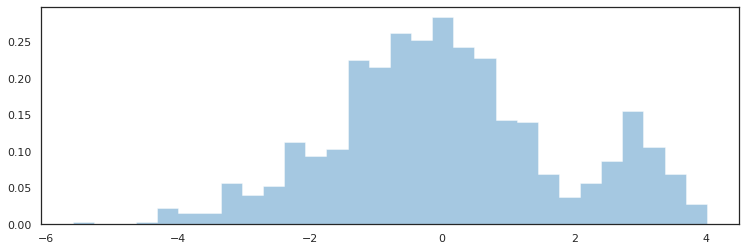

In [0]:
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

In [0]:
mixm = GaussianMixture(n_components=2, random_state=1, verbose=1)
mixm.fit(X)

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=1,
                verbose_interval=10, warm_start=False, weights_init=None)

(array([0.0031234 , 0.        , 0.        , 0.0031234 , 0.02186382,
        0.01561702, 0.01561702, 0.05622126, 0.04060424, 0.05309786,
        0.11244252, 0.0937021 , 0.10307231, 0.22488505, 0.21551484,
        0.26236589, 0.25299568, 0.28422971, 0.24362547, 0.22800845,
        0.14367656, 0.14055315, 0.06871488, 0.03748084, 0.05622126,
        0.0874553 , 0.15617017, 0.10619572, 0.06871488, 0.02811063]),
 array([-5.59621203, -5.27604846, -4.95588489, -4.63572131, -4.31555774,
        -3.99539416, -3.67523059, -3.35506702, -3.03490344, -2.71473987,
        -2.39457629, -2.07441272, -1.75424914, -1.43408557, -1.113922  ,
        -0.79375842, -0.47359485, -0.15343127,  0.1667323 ,  0.48689587,
         0.80705945,  1.12722302,  1.4473866 ,  1.76755017,  2.08771375,
         2.40787732,  2.72804089,  3.04820447,  3.36836804,  3.68853162,
         4.00869519]),
 <a list of 1 Patch objects>)

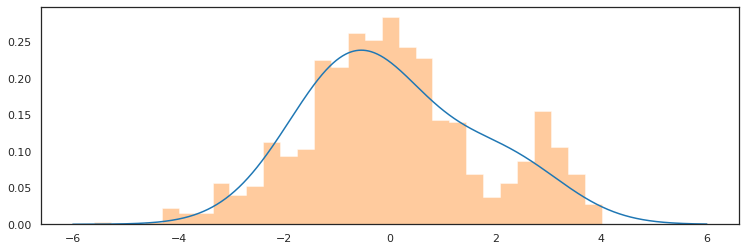

In [0]:
x = np.linspace(-6, 6, 1000)
logprob = mixm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
plt.plot(x, pdf)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

Does not look great for 2 clusters. Though it seems there are 2 clusters

(array([0.0031234 , 0.        , 0.        , 0.0031234 , 0.02186382,
        0.01561702, 0.01561702, 0.05622126, 0.04060424, 0.05309786,
        0.11244252, 0.0937021 , 0.10307231, 0.22488505, 0.21551484,
        0.26236589, 0.25299568, 0.28422971, 0.24362547, 0.22800845,
        0.14367656, 0.14055315, 0.06871488, 0.03748084, 0.05622126,
        0.0874553 , 0.15617017, 0.10619572, 0.06871488, 0.02811063]),
 array([-5.59621203, -5.27604846, -4.95588489, -4.63572131, -4.31555774,
        -3.99539416, -3.67523059, -3.35506702, -3.03490344, -2.71473987,
        -2.39457629, -2.07441272, -1.75424914, -1.43408557, -1.113922  ,
        -0.79375842, -0.47359485, -0.15343127,  0.1667323 ,  0.48689587,
         0.80705945,  1.12722302,  1.4473866 ,  1.76755017,  2.08771375,
         2.40787732,  2.72804089,  3.04820447,  3.36836804,  3.68853162,
         4.00869519]),
 <a list of 1 Patch objects>)

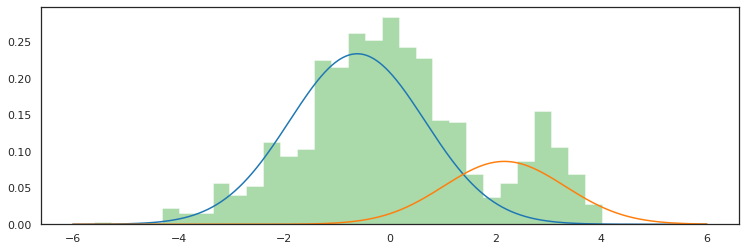

In [0]:
responsibilities = mixm.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.plot(x, pdf_individual)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

Looking at this, it looks like there has to be an extra cluster to the right because the two peaks seem ot be offset from the real peaks! So, as good data scientists, we wiil try another model that contains 3 gaussians!

In [0]:
mixm = GaussianMixture(n_components=3, random_state=1, verbose=1)
mixm.fit(X)

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=1,
                verbose_interval=10, warm_start=False, weights_init=None)

(array([0.0031234 , 0.        , 0.        , 0.0031234 , 0.02186382,
        0.01561702, 0.01561702, 0.05622126, 0.04060424, 0.05309786,
        0.11244252, 0.0937021 , 0.10307231, 0.22488505, 0.21551484,
        0.26236589, 0.25299568, 0.28422971, 0.24362547, 0.22800845,
        0.14367656, 0.14055315, 0.06871488, 0.03748084, 0.05622126,
        0.0874553 , 0.15617017, 0.10619572, 0.06871488, 0.02811063]),
 array([-5.59621203, -5.27604846, -4.95588489, -4.63572131, -4.31555774,
        -3.99539416, -3.67523059, -3.35506702, -3.03490344, -2.71473987,
        -2.39457629, -2.07441272, -1.75424914, -1.43408557, -1.113922  ,
        -0.79375842, -0.47359485, -0.15343127,  0.1667323 ,  0.48689587,
         0.80705945,  1.12722302,  1.4473866 ,  1.76755017,  2.08771375,
         2.40787732,  2.72804089,  3.04820447,  3.36836804,  3.68853162,
         4.00869519]),
 <a list of 1 Patch objects>)

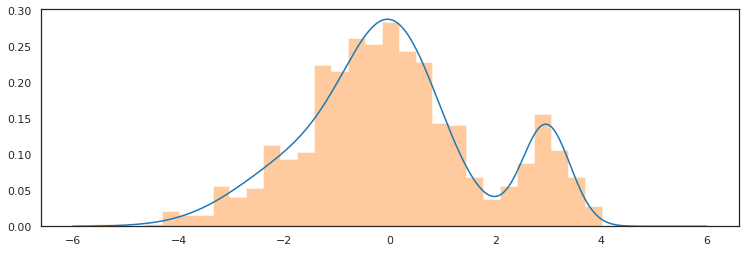

In [0]:
x = np.linspace(-6, 6, 1000)
logprob = mixm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
plt.plot(x, pdf)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

(array([0.0031234 , 0.        , 0.        , 0.0031234 , 0.02186382,
        0.01561702, 0.01561702, 0.05622126, 0.04060424, 0.05309786,
        0.11244252, 0.0937021 , 0.10307231, 0.22488505, 0.21551484,
        0.26236589, 0.25299568, 0.28422971, 0.24362547, 0.22800845,
        0.14367656, 0.14055315, 0.06871488, 0.03748084, 0.05622126,
        0.0874553 , 0.15617017, 0.10619572, 0.06871488, 0.02811063]),
 array([-5.59621203, -5.27604846, -4.95588489, -4.63572131, -4.31555774,
        -3.99539416, -3.67523059, -3.35506702, -3.03490344, -2.71473987,
        -2.39457629, -2.07441272, -1.75424914, -1.43408557, -1.113922  ,
        -0.79375842, -0.47359485, -0.15343127,  0.1667323 ,  0.48689587,
         0.80705945,  1.12722302,  1.4473866 ,  1.76755017,  2.08771375,
         2.40787732,  2.72804089,  3.04820447,  3.36836804,  3.68853162,
         4.00869519]),
 <a list of 1 Patch objects>)

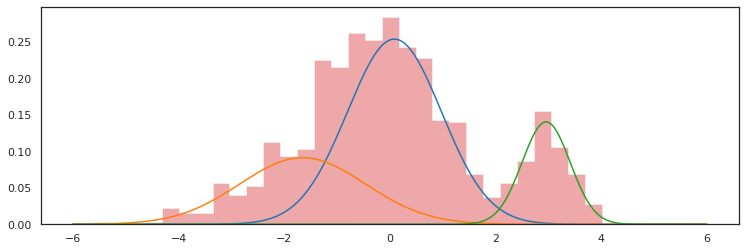

In [0]:
responsibilities = mixm.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.plot(x, pdf_individual)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

In [0]:
# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

 let's compute some information criteria to help us pick the best possible model.

The two most popular information criteria for statistical models are Akaike's Information criterion (AIC), discovered by the statistician Hirotugu Akaike, and the Bayesian information criterion (BIC), discovered by Gideon E. Schwarz, both of which are included in scikit-learn!

In [0]:
# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

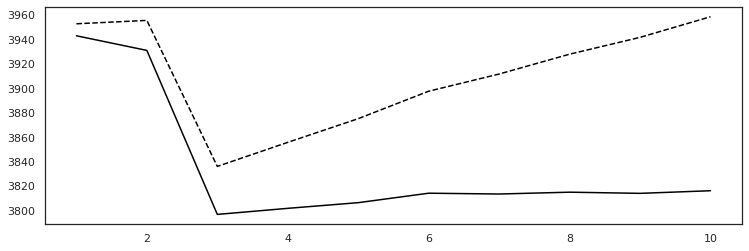

In [0]:
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')

We see immediately that the best possible model is for 3 gaussian clusters.